In [1]:
from scipy import ndimage
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import FormatStrFormatter

import cartopy.crs as ccrs

import os
from pathlib import Path

Populating the interactive namespace from numpy and matplotlib


In [2]:
from hypercc.data.box import Box
from hypercc.data.data_set import DataSet
from hypercc.units import unit
from hypercc.filters import (taper_masked_area, gaussian_filter, sobel_filter)
from hypercc.plotting import (
    plot_mollweide, plot_orthographic_np, plot_plate_carree,
    plot_signal_histogram, earth_plot)
from hypercc.calibration import (calibrate_sobel)

from hyper_canny import cp_edge_thinning, cp_double_threshold

## Enter your settings here

In [3]:
data_folder = Path("/home/bathiany/Sebastian/datamining/edges/obsscan")

#data_set = DataSet([data_folder / 'ERA5_T2m_daily_normalised_JJA_2010_t100.nc'], 't2m')
#data_set = DataSet([data_folder / 'ERA5_T2m_daily_normalised_JJA_2008-2012_t100.nc'], 't2m')
data_set = DataSet([data_folder / 'ERA5_T2m_daily_normalised_JJA_2000-2018_t42.nc'], 't2m')
#data_set = DataSet([data_folder / 'ERA5_T2m_daily_normalised_JJA_t100.nc'], 't2m')
year_ini=2000
daysperyear=92

## smoothing scales
sigma_d = unit('50 km')    # space
sigma_t = unit('5 days')    # time

### aspect ratio: all weight on time
gamma = 0.00001
scaling_factor = gamma * unit('1 km/year')
sobel_delta_t = unit('1 year')
sobel_delta_d = sobel_delta_t * scaling_factor
sobel_weights = [sobel_delta_t, sobel_delta_d, sobel_delta_d]

# select data based on settings above
## No editing below this point required

## Load and inspect the data

Next we define a `box`. The box contains all information on the geometry of the data. It loads the lattitudes and longitudes of the grid points from the NetCDF file and computes quantities like resolution.

In [4]:
from datetime import date, timedelta

box = data_set.box

print("({:.6~P}, {:.6~P}, {:.6~P}) per pixel".format(*box.resolution))
for t in box.time[:3]:
    print(box.date(t), end=', ')
print(" ...")

dt = box.time[1:] - box.time[:-1]
print("time steps: max", dt.max(), "min", dt.min())

(0.250897 year, 310.239 km, 312.736 km) per pixel
2000-06-01, 2000-06-02, 2000-06-03,  ...
time steps: max 6600.0 min 24.0


In [5]:
#yearly_data_set = data_set
#box = yearly_data_set.box
data = data_set.data

In [7]:
# integrate data over time
data_int=data*0.0

for timeind in range(0,np.shape(data)[0]):
    data_int[timeind,:,:]=np.sum(data[0:timeind,:,:],axis=0)

In [8]:
times=np.shape(data)[0]
years=linspace(year_ini, 2018, 2018-year_ini+1)
days=linspace(1/daysperyear,times/daysperyear,times)+year_ini

In [11]:
# Smoothing
smooth_data = gaussian_filter(box, data_int, [sigma_t, sigma_d, sigma_d])

### Sobel filtering
The Sobel filter has the same problem as the Gaussian filter, but the solution is easier. We just correct for the magnitude of the Sobel response by multiplying the longitudinal component by the cosine of the latitude.

In [12]:
sb = sobel_filter(box, smooth_data, weight=sobel_weights)
pixel_sb = sobel_filter(box, smooth_data, physical=False)

### Determine hysteresis settings

In [13]:
signal = 1/sb[3]

In [14]:
## quartiles

signalarray = np.asarray(signal).reshape(-1)
signal_no0 = np.ma.masked_equal(signalarray,0)
signal_no0=signal_no0.compressed()

#np.percentile(signal_no0, [25, 50, 75, 100])

In [15]:
## There is no control data for observations => must choose thresholds based on data itself.
# Here, use 75 and 50%ile (quartiles 2 and 3)

upper_threshold=np.percentile(signal_no0, 99.99)
lower_threshold=np.percentile(signal_no0, 95)

In [16]:
from hyper_canny import cp_edge_thinning, cp_double_threshold

In [17]:
# use directions of pixel based sobel transform and magnitudes from calibrated physical sobel.
dat = pixel_sb.transpose([3,2,1,0]).astype('float32')
dat[:,:,:,3] = sb[3].transpose([2,1,0])
mask = cp_edge_thinning(dat)
thinned = mask.transpose([2, 1, 0])
dat = sb.transpose([3,2,1,0]).copy().astype('float32')

In [18]:
edges = cp_double_threshold(data=dat, mask=mask, a=1/upper_threshold, b=1/lower_threshold)
m = edges.transpose([2, 1, 0])

## quantifying the abruptness in time:

In [68]:
cutoff_length=30       # how many days to either side of the abrupt shift are cut off (the index of the event itself is always cut off)
chunk_max_length=daysperyear*5   # maximum length of chunk of time series to either side of the event
chunk_min_length=daysperyear*2   # minimum length of these chunks


In [69]:
#days = np.array([d.year for d in box.dates])
edges = cp_double_threshold(data=dat, mask=thinned.transpose([2,1,0]), a=1/upper_threshold, b=1/lower_threshold)
m = edges.transpose([2, 1, 0])
idx = np.where(m)
indices=np.asarray(idx)
abruptness3d=m*0.0

shapeidx=np.shape(idx)
nofresults=shapeidx[1]

for result in range(nofresults):
    [dim0,dim1,dim2]=indices[:,result]

    if m[dim0, dim1, dim2] == 1:
        index=dim0

        if ( index-cutoff_length >= 0 ) and ( index + cutoff_length + 1 <= np.size(data_int,axis=0) ):
            chunk1_data=data_int[0:index-cutoff_length,dim1,dim2]
            chunk2_data=data_int[index+cutoff_length+1:,dim1,dim2]
            chunk1_days=days[0:index-cutoff_length]
            chunk2_days=days[index+cutoff_length+1:]    
            
            if size(chunk1_data) > chunk_max_length:
                chunk1_start=size(chunk1_data)-chunk_max_length
            else:
                chunk1_start=0  
            if size(chunk2_data) > chunk_max_length:
                chunk2_end=chunk_max_length
            else:
                chunk2_end=size(chunk2_data)

            chunk1_data_short=chunk1_data[chunk1_start:]
            chunk2_data_short=chunk2_data[0:chunk2_end]                

            N1=size(chunk1_data_short)
            N2=size(chunk2_data_short)
                
            if not ((N1 < chunk_min_length) or (N2 < chunk_min_length)):
                chunk1_days_short=chunk1_days[chunk1_start:]-days[dim0]
                chunk2_days_short=chunk2_days[0:chunk2_end]-days[dim0]
        
                slope_chunk1, intercept_chunk1, r_value, p_value, std_err = stats.linregress(chunk1_days_short, chunk1_data_short)
                chunk1_regline=intercept_chunk1 + slope_chunk1*chunk1_days_short
            
                slope_chunk2, intercept_chunk2, r_value, p_value, std_err = stats.linregress(chunk2_days_short, chunk2_data_short)
                chunk2_regline=intercept_chunk2 + slope_chunk2*chunk2_days_short
            
                mean_std=(np.nanstd(chunk1_data_short)+np.nanstd(chunk2_data_short))/2
                abruptness3d[dim0,dim1,dim2]=abs(intercept_chunk1-intercept_chunk2)/mean_std

abruptness=np.max(abruptness3d,axis=0)


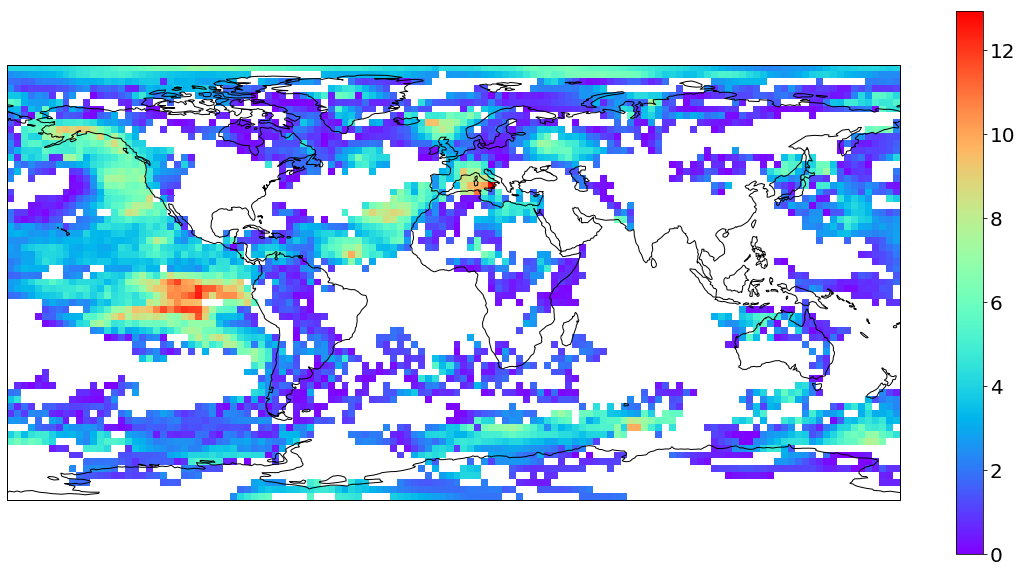

In [70]:
# map of the maximum abruptness at each point
plot_plate_carree(box, abruptness, cmap=my_cmap, vmin=1e-10)

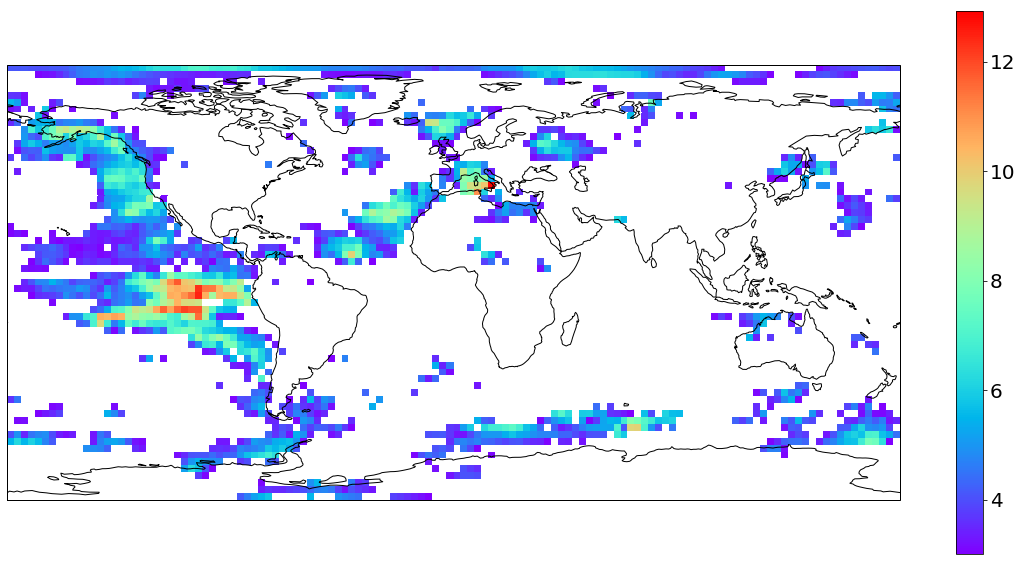

In [33]:
# map of the maximum abruptness at each point
plot_plate_carree(box, abruptness, cmap=my_cmap, vmin=3)

## when does largest abruptness occur: 

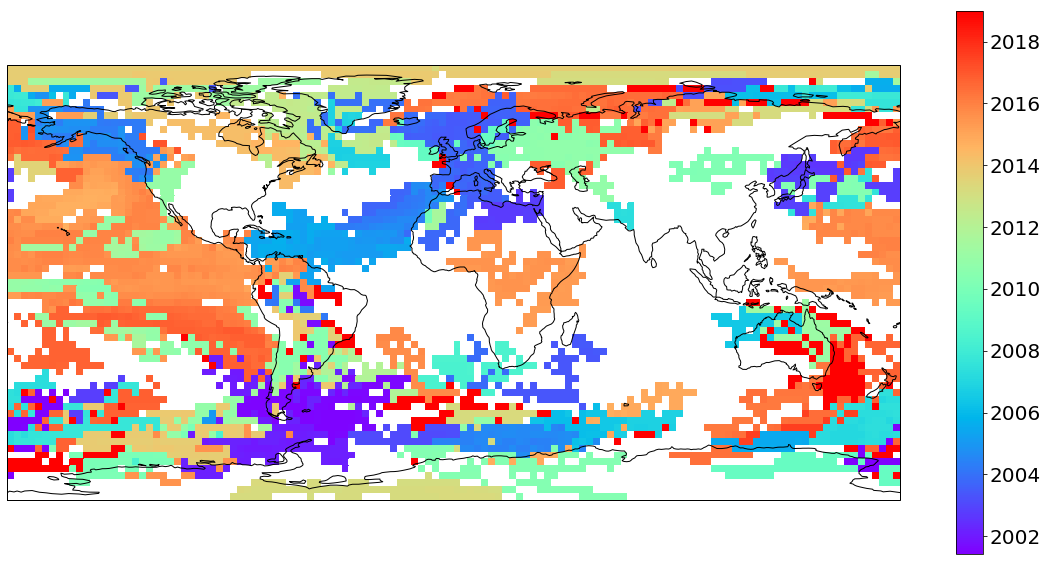

In [27]:
mask_max=m*0
for lonind in range(0,np.shape(data)[2]):
    for latind in range(0,np.shape(data)[1]):
        for timeind in range(0,times):
            if abruptness3d[timeind, latind, lonind] == abruptness[latind,lonind]:
                mask_max[timeind, latind, lonind] = 1

days_maxpeak=(days[:,None,None]*mask_max).max(axis=0)
maxm=np.nanmax(m, axis=0)
days_maxpeak=days_maxpeak*maxm

minval = np.min(days_maxpeak[np.nonzero(days_maxpeak)])
maxval= np.max(days_maxpeak)
plot_plate_carree(box, days_maxpeak,  cmap=my_cmap, vmin=minval, vmax=maxval)

## illustration of individual events identified on the maps above:

In [ ]:
fntsiz=40
plt.rcParams['figure.figsize'] = (25, 15)

In [ ]:
# Western Russia: Russian Heatwave 2010

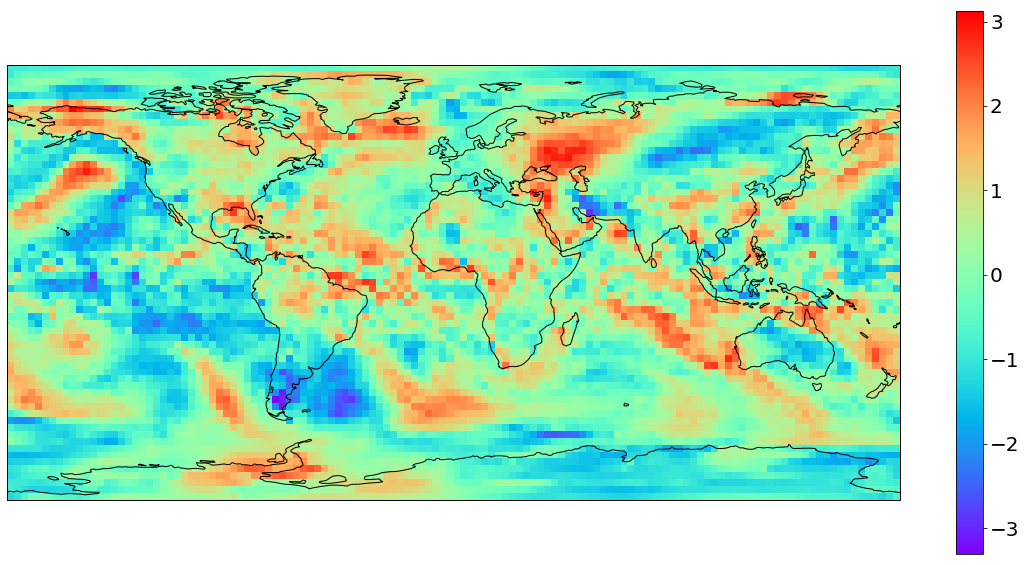

In [36]:
# situation on 1st August 2010
my_cmap = matplotlib.cm.get_cmap('rainbow')  #YlGnBu
my_cmap.set_under('w')
plot_plate_carree(box, data[62+daysperyear*(year_ini-2009),:,:],  cmap=my_cmap)

In [149]:
latind=12
lonind=13

<Figure size 1800x1080 with 0 Axes>

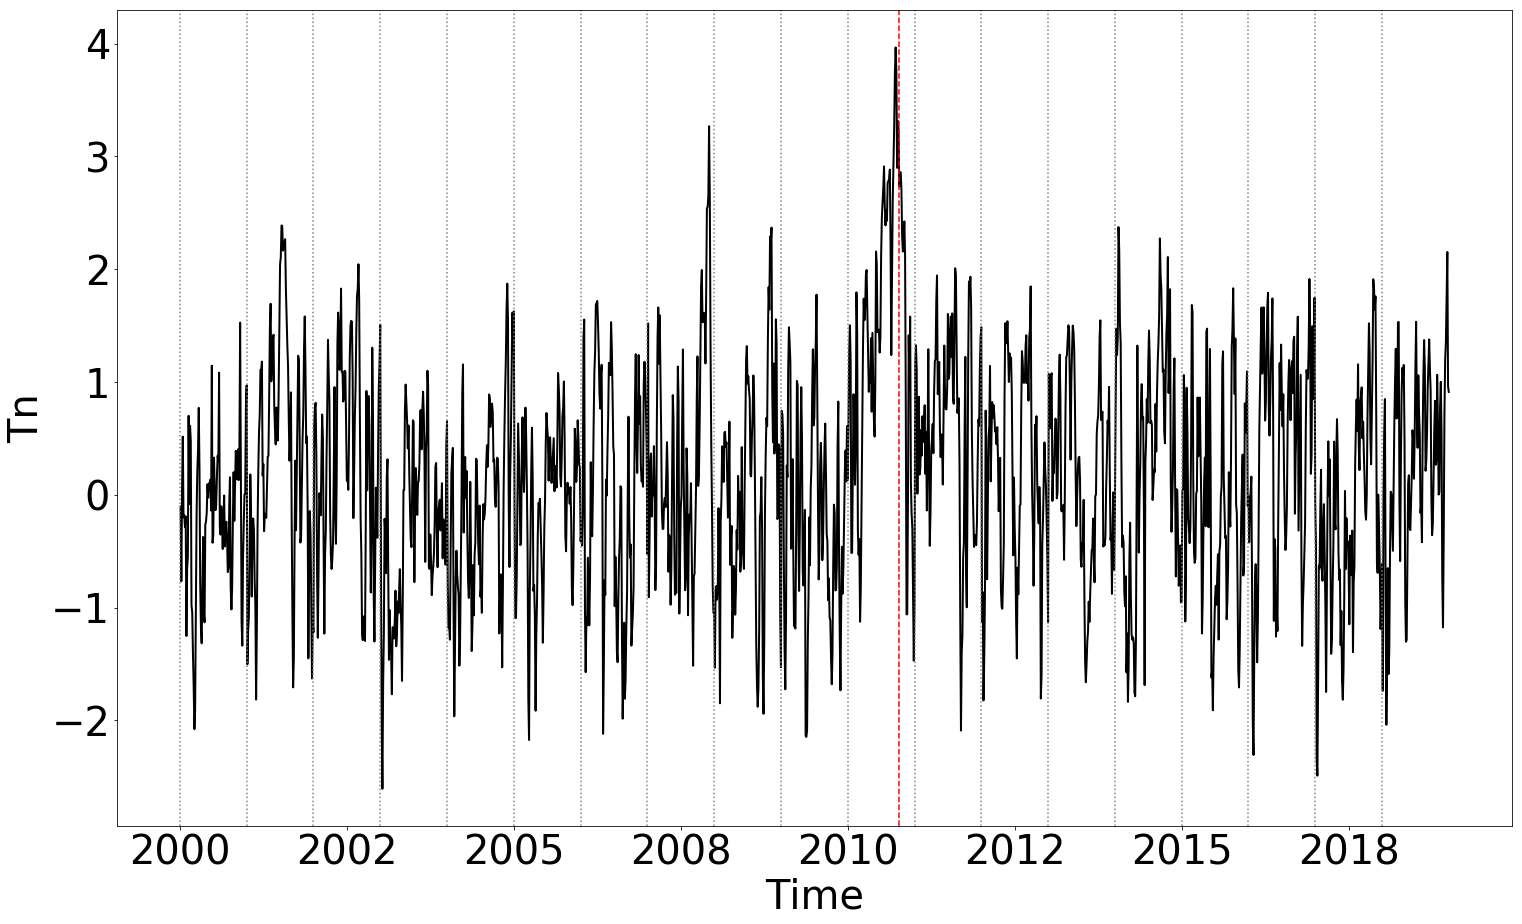

In [150]:
ts=data[:,latind,lonind]
abruptness_max=abruptness[latind,lonind]
fig = plt.figure()

fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

ax.plot(days, ts, 'k', linewidth='2')

## determine year of abrupt shift
index=np.where(abruptness3d[:,latind,lonind]==abruptness_max)

ax.axvline(x=days[index], ymin=0, ymax=1, color='r', linestyle="--")

plt.ylabel('Tn', fontsize=fntsiz)
plt.xlabel('Time', fontsize=fntsiz)
matplotlib.rc('xtick', labelsize=fntsiz) 
matplotlib.rc('ytick', labelsize=fntsiz) 
ax.tick_params(axis='both', which='major', labelsize=fntsiz)
for year in years:
    ax.axvline(x=year, ymin=0, ymax=1, color='gray', linestyle=":")

ymin=min(ts)
ymax=max(ts)
xmin=min(days)
xmax=max(days)
xrange=xmax-xmin
yrange=ymax-ymin
frac=0.025
ypos=ymax-0.025*yrange
xpos=xmin+0.01*xrange


<Figure size 1800x1080 with 0 Axes>

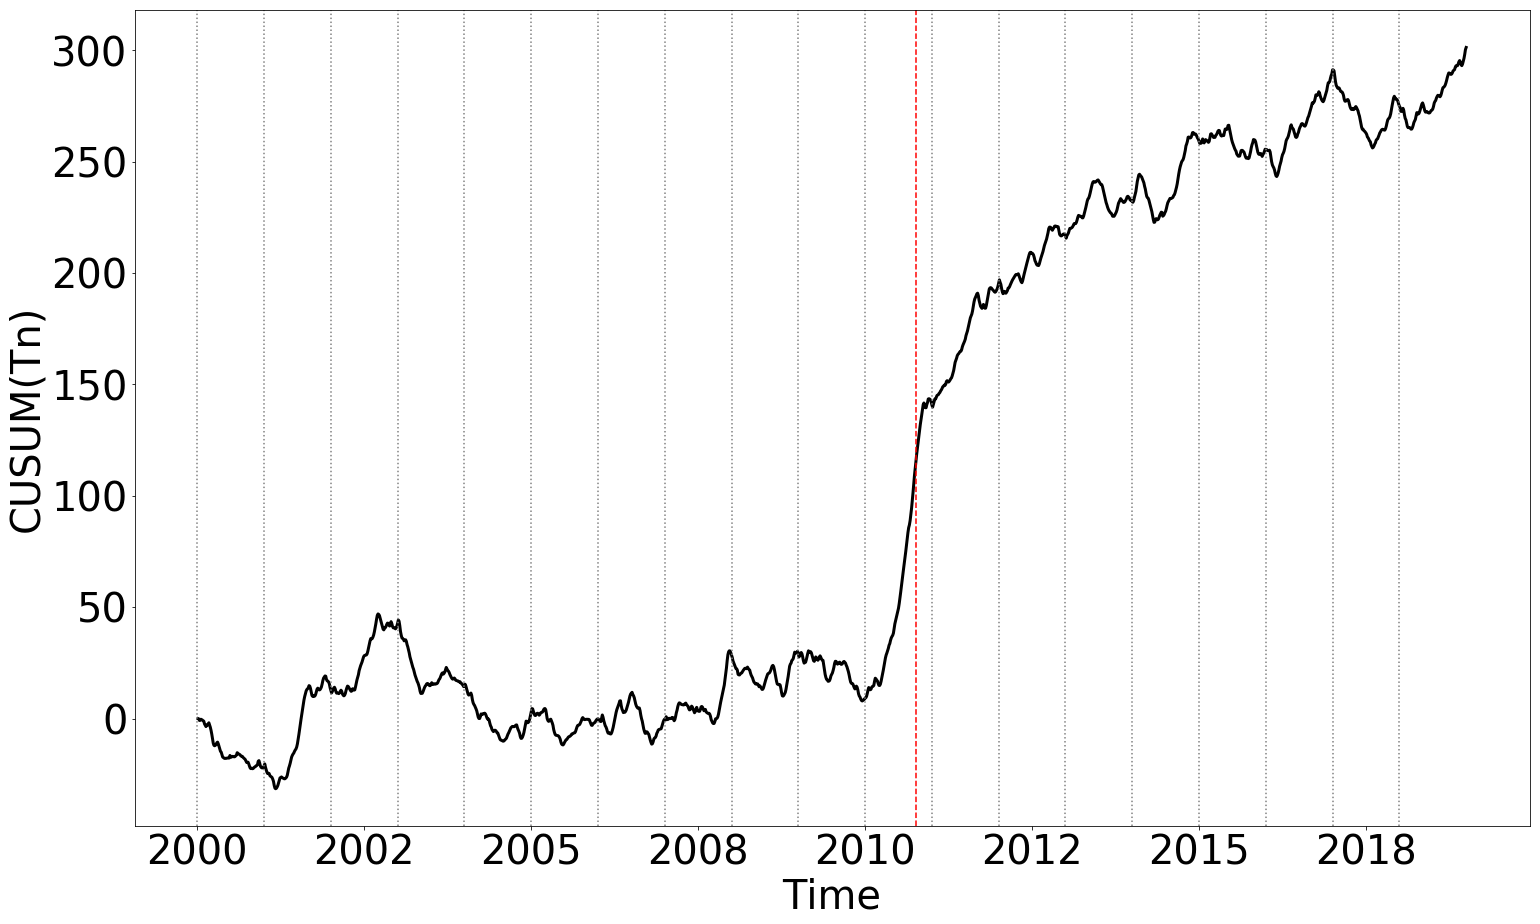

In [151]:
ts=data_int[:,latind,lonind]
fig = plt.figure()
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.plot(days, ts, 'k', linewidth='3')

ax.axvline(x=days[index], ymin=0, ymax=1, color='r', linestyle="--")

plt.ylabel('CUSUM(Tn)', fontsize=fntsiz)
plt.xlabel('Time', fontsize=fntsiz)
matplotlib.rc('xtick', labelsize=fntsiz) 
matplotlib.rc('ytick', labelsize=fntsiz) 
ax.tick_params(axis='both', which='major', labelsize=fntsiz)
for year in years:
    ax.axvline(x=year, ymin=0, ymax=1, color='gray', linestyle=":")

ymin=min(ts)
ymax=max(ts)
yrange=ymax-ymin
frac=0.025
ypos=ymax-0.025*yrange
xpos=xmin+0.01*xrange
#ax.text(xpos,ypos,'abruptness: '+ '{:f}'.format(abruptness_max),color='r', size=fntsiz)

In [155]:
# Pacific Ocean: El Nino 2015/16
latind=33
lonind=89

<Figure size 1800x1080 with 0 Axes>

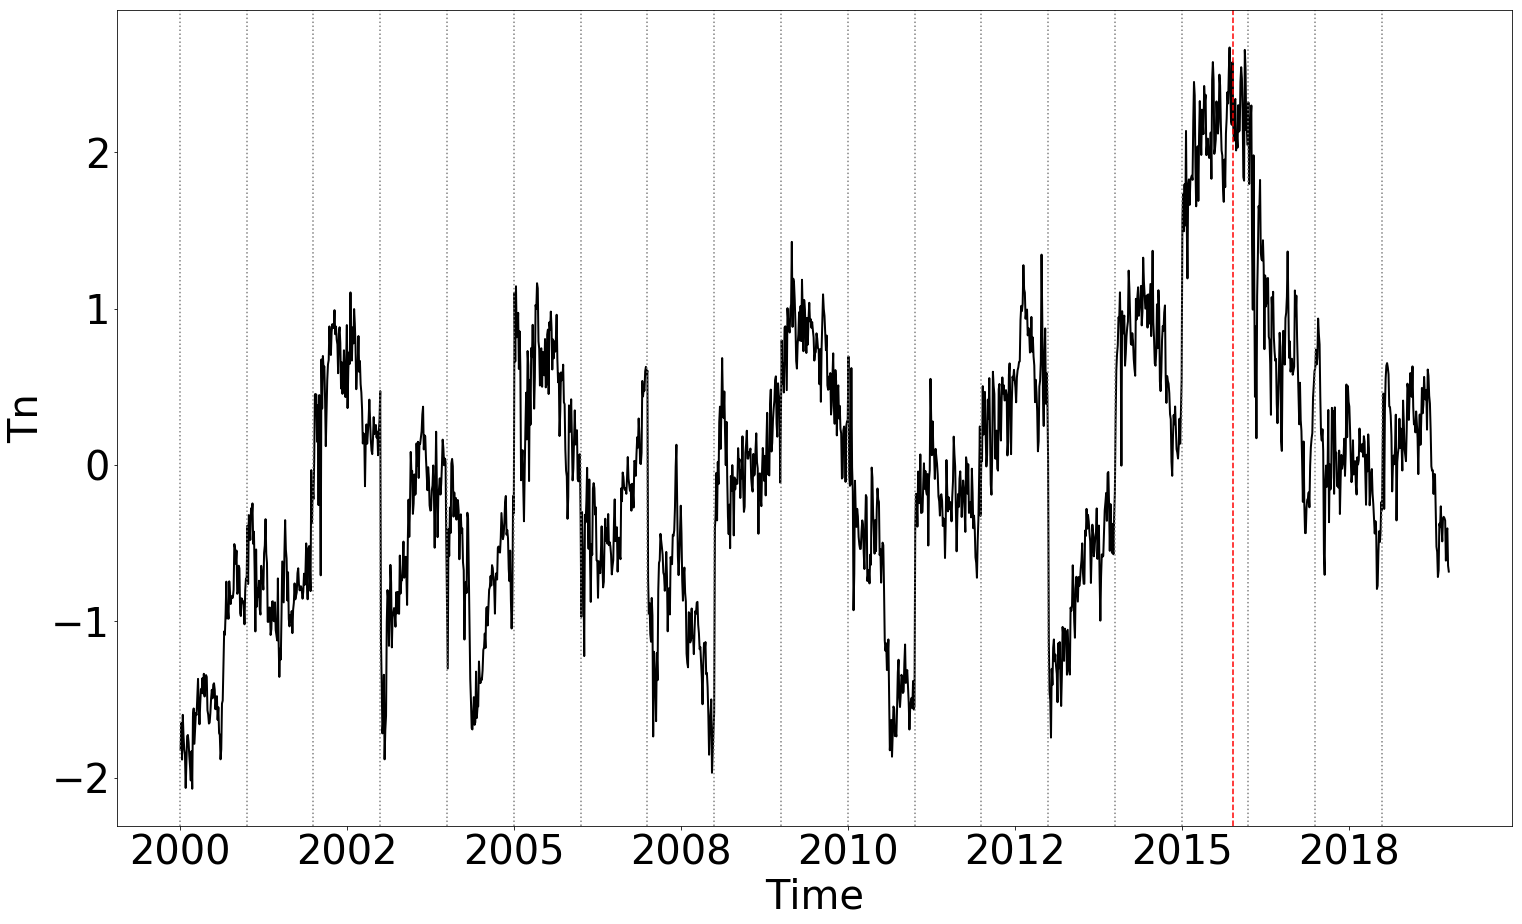

In [156]:
ts=data[:,latind,lonind]
abruptness_max=abruptness[latind,lonind]
fig = plt.figure()

fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

ax.plot(days, ts, 'k', linewidth='2')

## determine year of abrupt shift
index=np.where(abruptness3d[:,latind,lonind]==abruptness_max)

ax.axvline(x=days[index], ymin=0, ymax=1, color='r', linestyle="--")

plt.ylabel('Tn', fontsize=fntsiz)
plt.xlabel('Time', fontsize=fntsiz)
matplotlib.rc('xtick', labelsize=fntsiz) 
matplotlib.rc('ytick', labelsize=fntsiz) 
ax.tick_params(axis='both', which='major', labelsize=fntsiz)
for year in years:
    ax.axvline(x=year, ymin=0, ymax=1, color='gray', linestyle=":")

ymin=min(ts)
ymax=max(ts)
xmin=min(days)
xmax=max(days)
xrange=xmax-xmin
yrange=ymax-ymin
frac=0.025
ypos=ymax-0.025*yrange
xpos=xmin+0.01*xrange


<Figure size 1800x1080 with 0 Axes>

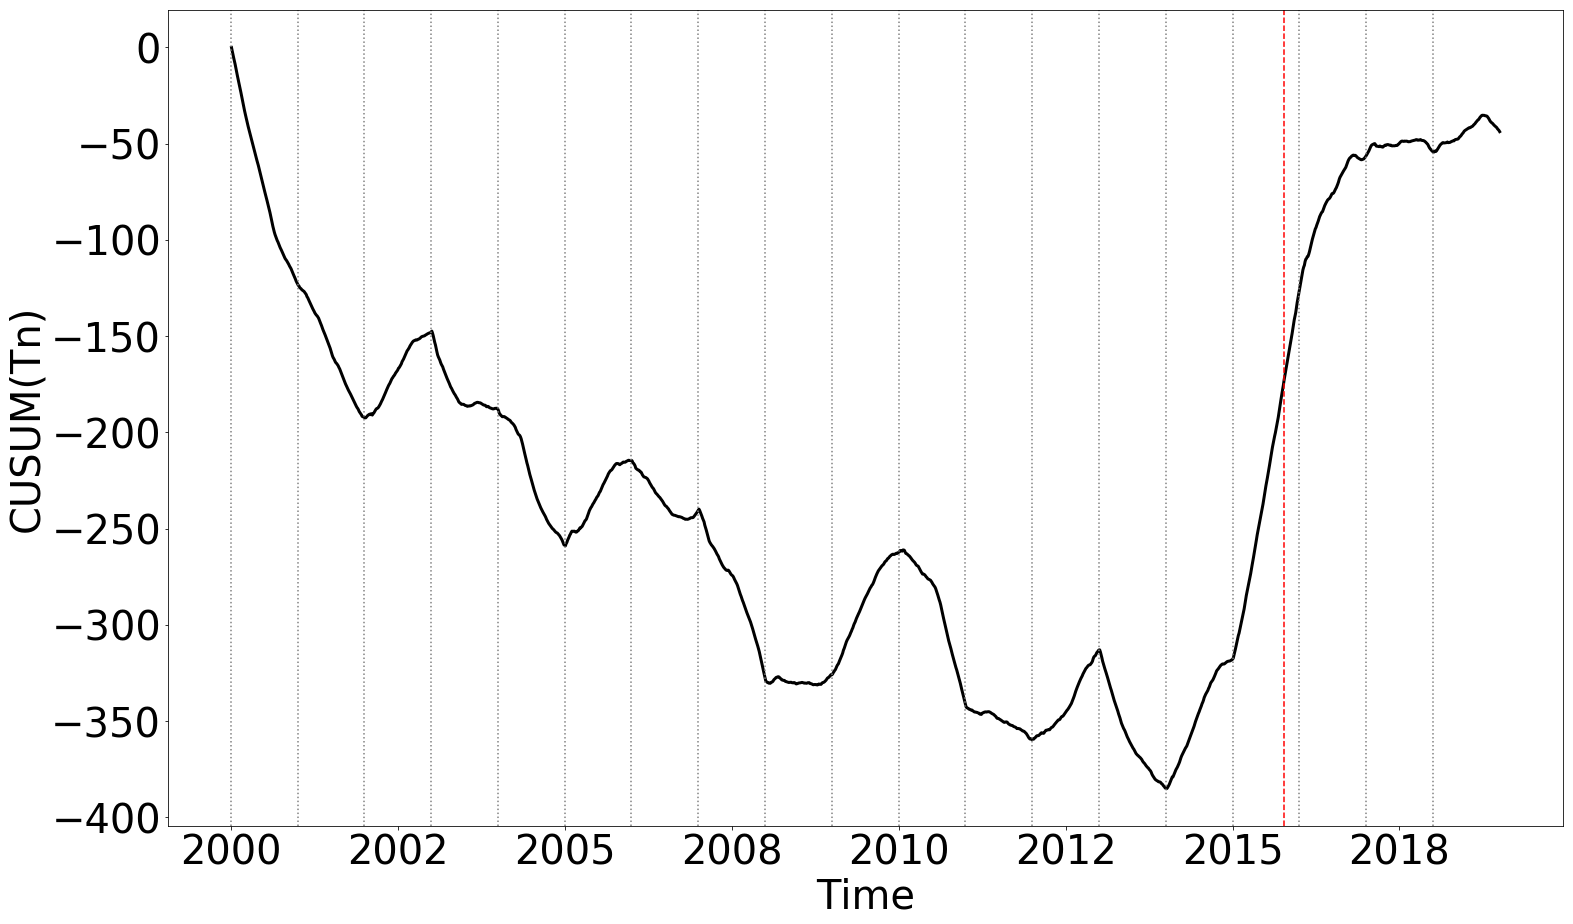

In [157]:
ts=data_int[:,latind,lonind]
fig = plt.figure()
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.plot(days, ts, 'k', linewidth='3')

ax.axvline(x=days[index], ymin=0, ymax=1, color='r', linestyle="--")

plt.ylabel('CUSUM(Tn)', fontsize=fntsiz)
plt.xlabel('Time', fontsize=fntsiz)
matplotlib.rc('xtick', labelsize=fntsiz) 
matplotlib.rc('ytick', labelsize=fntsiz) 
ax.tick_params(axis='both', which='major', labelsize=fntsiz)
for year in years:
    ax.axvline(x=year, ymin=0, ymax=1, color='gray', linestyle=":")

ymin=min(ts)
ymax=max(ts)
yrange=ymax-ymin
frac=0.025
ypos=ymax-0.025*yrange
xpos=xmin+0.01*xrange
#ax.text(xpos,ypos,'abruptness: '+ '{:f}'.format(abruptness_max),color='r', size=fntsiz)

In [158]:
# Southern Alaska
latind=9
lonind=73

<Figure size 1800x1080 with 0 Axes>

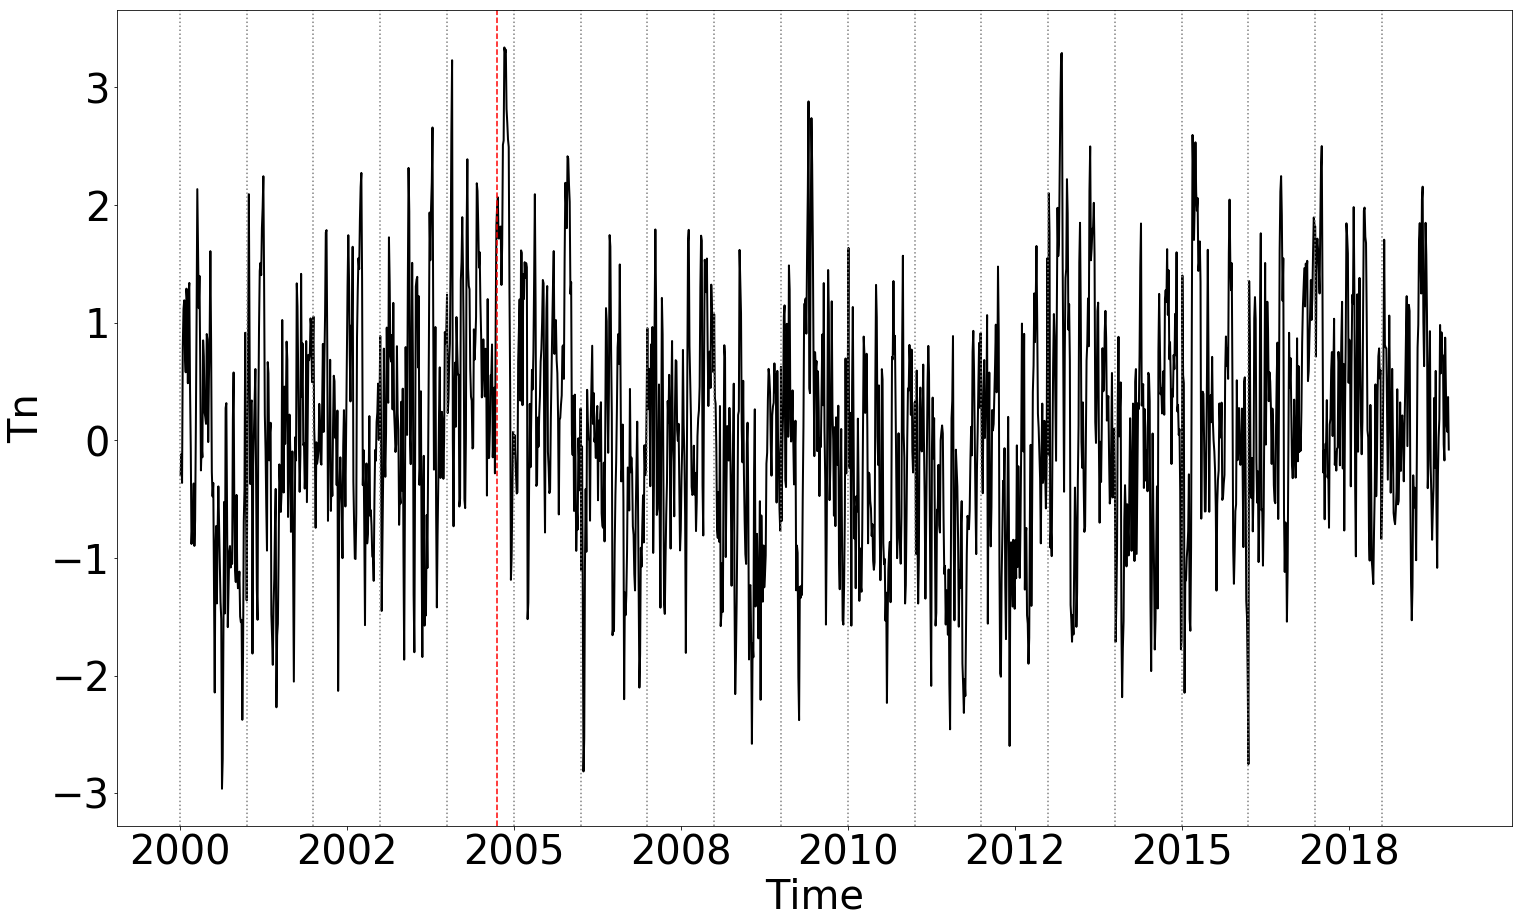

In [159]:
ts=data[:,latind,lonind]
abruptness_max=abruptness[latind,lonind]
fig = plt.figure()

fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.plot(days, ts, 'k', linewidth='2')

## determine year of abrupt shift
index=np.where(abruptness3d[:,latind,lonind]==abruptness_max)

ax.axvline(x=days[index], ymin=0, ymax=1, color='r', linestyle="--")

plt.ylabel('Tn', fontsize=fntsiz)
plt.xlabel('Time', fontsize=fntsiz)
matplotlib.rc('xtick', labelsize=fntsiz) 
matplotlib.rc('ytick', labelsize=fntsiz) 
ax.tick_params(axis='both', which='major', labelsize=fntsiz)
for year in years:
    ax.axvline(x=year, ymin=0, ymax=1, color='gray', linestyle=":")

ymin=min(ts)
ymax=max(ts)
xmin=min(days)
xmax=max(days)
xrange=xmax-xmin
yrange=ymax-ymin
frac=0.025
ypos=ymax-0.025*yrange
xpos=xmin+0.01*xrange


<Figure size 1800x1080 with 0 Axes>

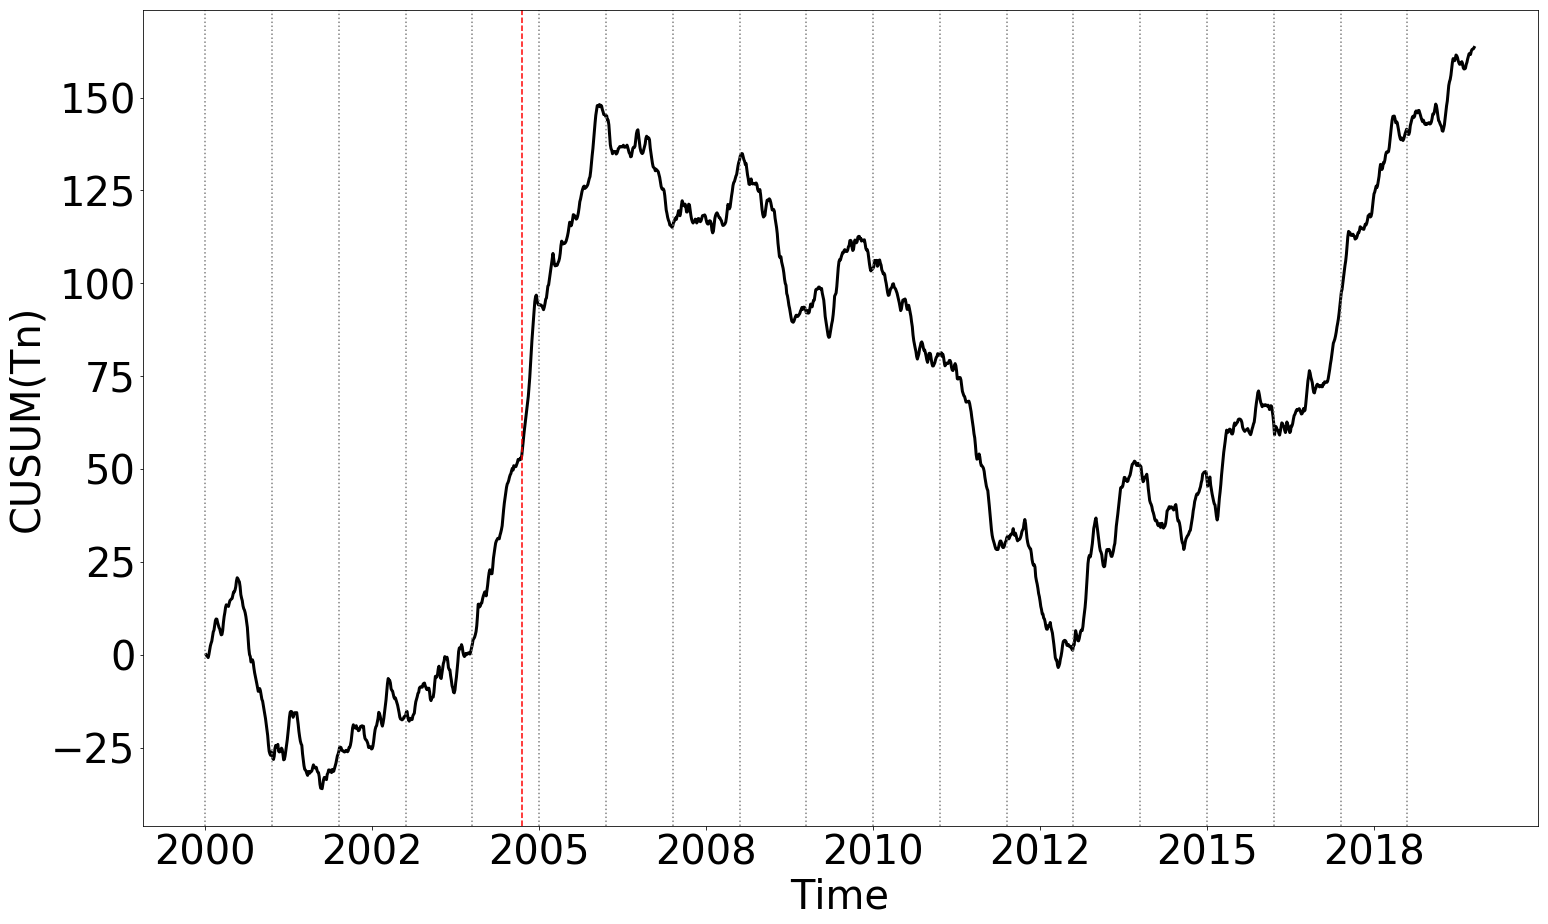

In [160]:
ts=data_int[:,latind,lonind]
fig = plt.figure()
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.plot(days, ts, 'k', linewidth='3')

ax.axvline(x=days[index], ymin=0, ymax=1, color='r', linestyle="--")

plt.ylabel('CUSUM(Tn)', fontsize=fntsiz)
plt.xlabel('Time', fontsize=fntsiz)
matplotlib.rc('xtick', labelsize=fntsiz) 
matplotlib.rc('ytick', labelsize=fntsiz) 
ax.tick_params(axis='both', which='major', labelsize=fntsiz)
for year in years:
    ax.axvline(x=year, ymin=0, ymax=1, color='gray', linestyle=":")

ymin=min(ts)
ymax=max(ts)
yrange=ymax-ymin
frac=0.025
ypos=ymax-0.025*yrange
xpos=xmin+0.01*xrange
#ax.text(xpos,ypos,'abruptness: '+ '{:f}'.format(abruptness_max),color='r', size=fntsiz)

In [164]:
# Southern France: Heat wave 2003
latind=16
lonind=1

<Figure size 1800x1080 with 0 Axes>

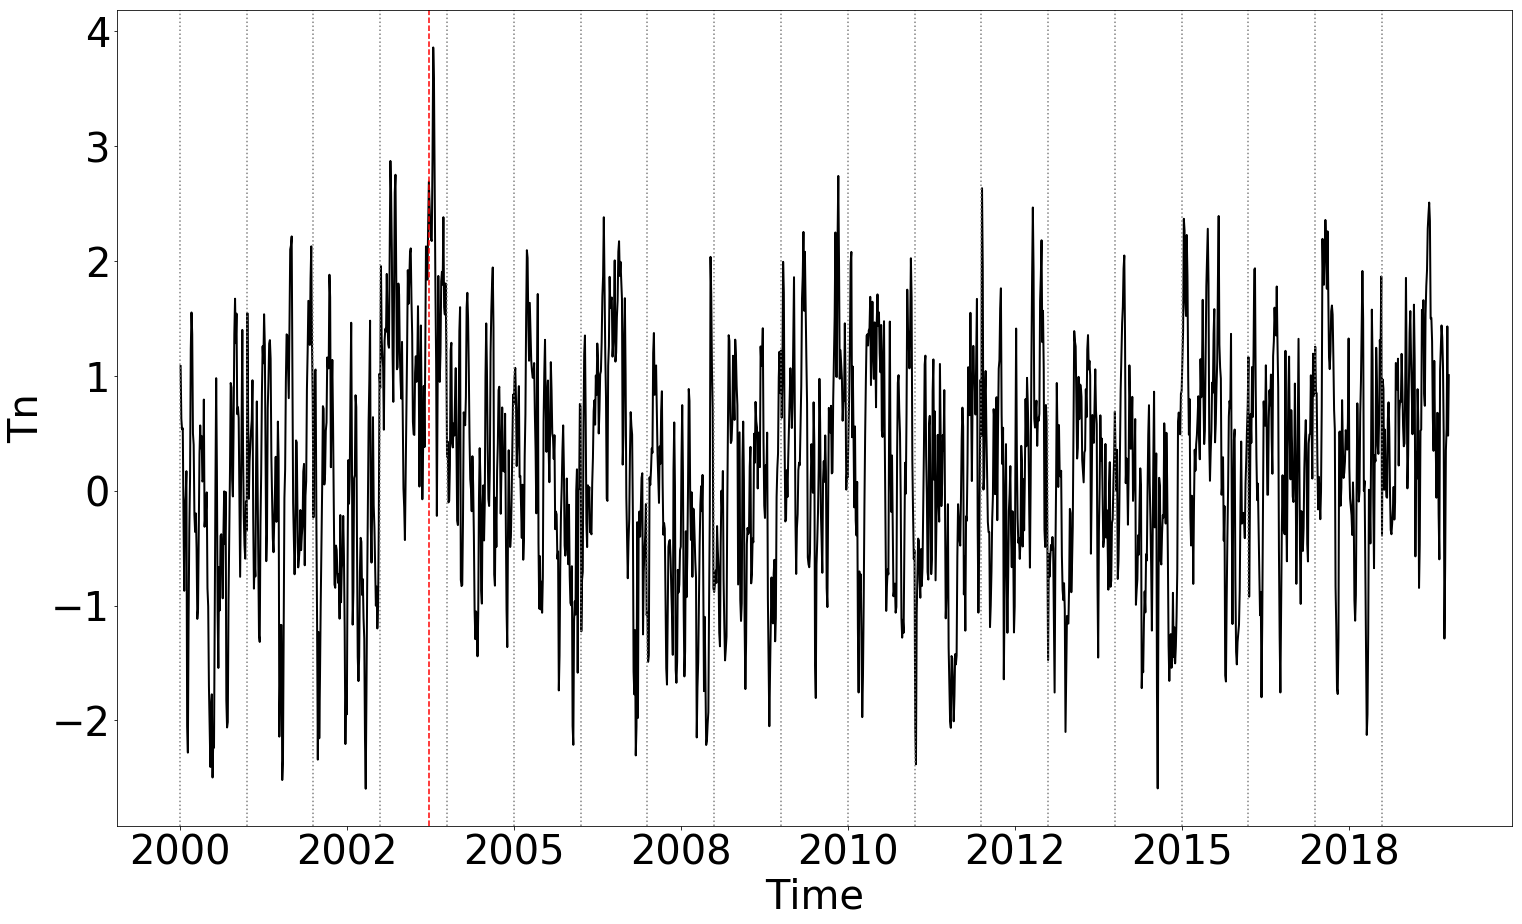

In [165]:
ts=data[:,latind,lonind]
abruptness_max=abruptness[latind,lonind]
fig = plt.figure()

fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

ax.plot(days, ts, 'k', linewidth='2')

## determine year of abrupt shift
index=np.where(abruptness3d[:,latind,lonind]==abruptness_max)

ax.axvline(x=days[index], ymin=0, ymax=1, color='r', linestyle="--")

plt.ylabel('Tn', fontsize=fntsiz)
plt.xlabel('Time', fontsize=fntsiz)
matplotlib.rc('xtick', labelsize=fntsiz) 
matplotlib.rc('ytick', labelsize=fntsiz) 
ax.tick_params(axis='both', which='major', labelsize=fntsiz)
for year in years:
    ax.axvline(x=year, ymin=0, ymax=1, color='gray', linestyle=":")

ymin=min(ts)
ymax=max(ts)
xmin=min(days)
xmax=max(days)
xrange=xmax-xmin
yrange=ymax-ymin
frac=0.025
ypos=ymax-0.025*yrange
xpos=xmin+0.01*xrange


<Figure size 1800x1080 with 0 Axes>

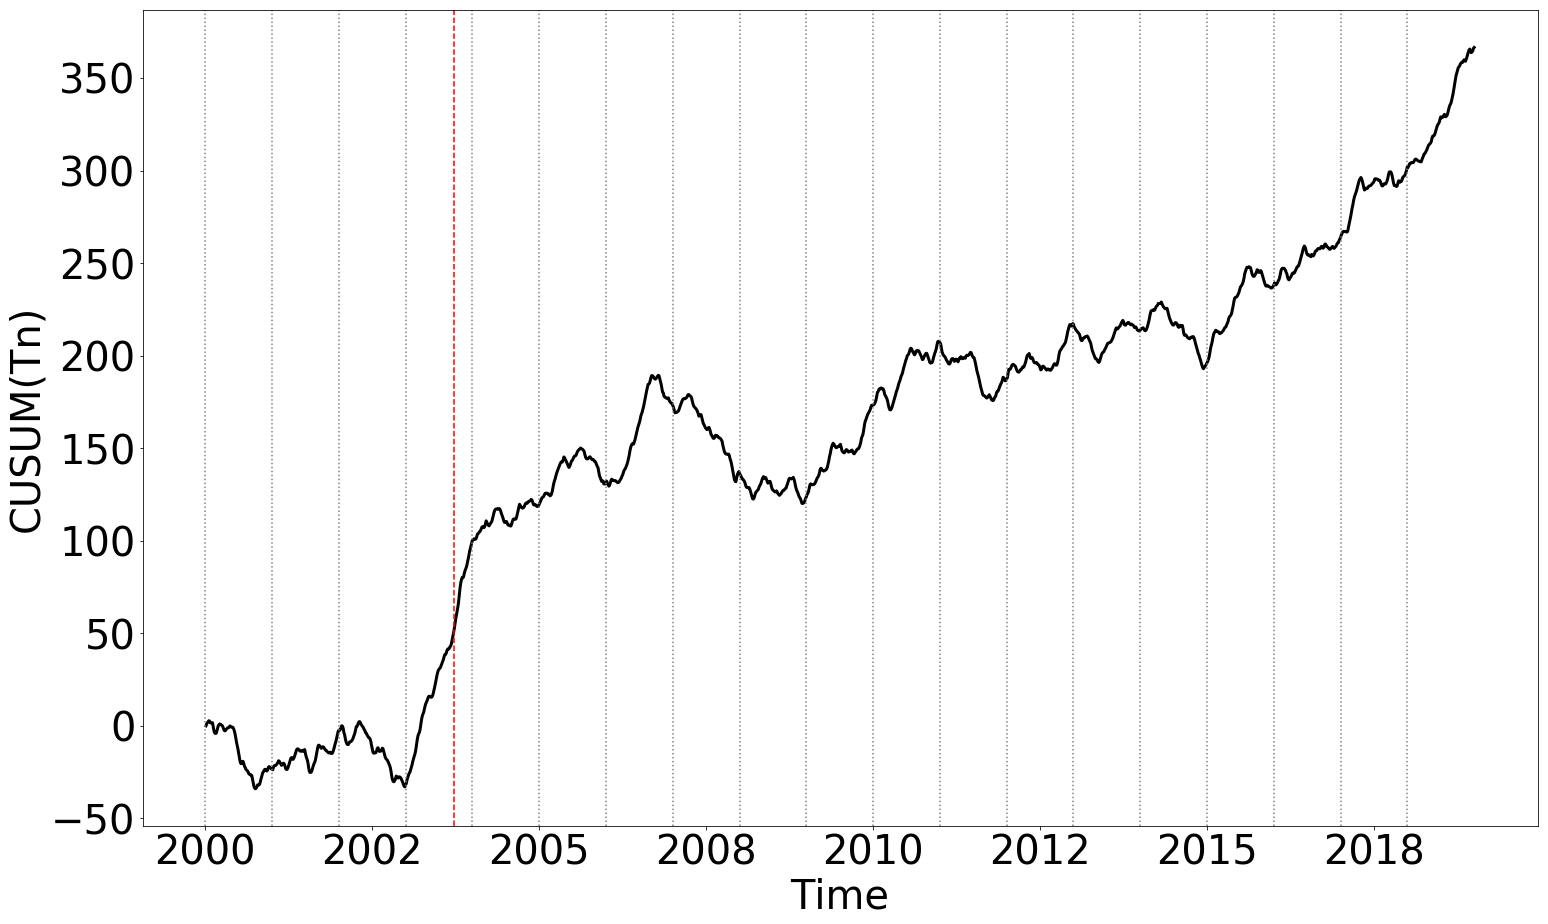

In [166]:
ts=data_int[:,latind,lonind]
fig = plt.figure()
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.plot(days, ts, 'k', linewidth='3')

ax.axvline(x=days[index], ymin=0, ymax=1, color='r', linestyle="--")

plt.ylabel('CUSUM(Tn)', fontsize=fntsiz)
plt.xlabel('Time', fontsize=fntsiz)
matplotlib.rc('xtick', labelsize=fntsiz) 
matplotlib.rc('ytick', labelsize=fntsiz) 
ax.tick_params(axis='both', which='major', labelsize=fntsiz)
for year in years:
    ax.axvline(x=year, ymin=0, ymax=1, color='gray', linestyle=":")

ymin=min(ts)
ymax=max(ts)
yrange=ymax-ymin
frac=0.025
ypos=ymax-0.025*yrange
xpos=xmin+0.01*xrange
#ax.text(xpos,ypos,'abruptness: '+ '{:f}'.format(abruptness_max),color='r', size=fntsiz)

In [152]:
# Southern Italy: Heat wave 2003
latind=17
lonind=5

<Figure size 1800x1080 with 0 Axes>

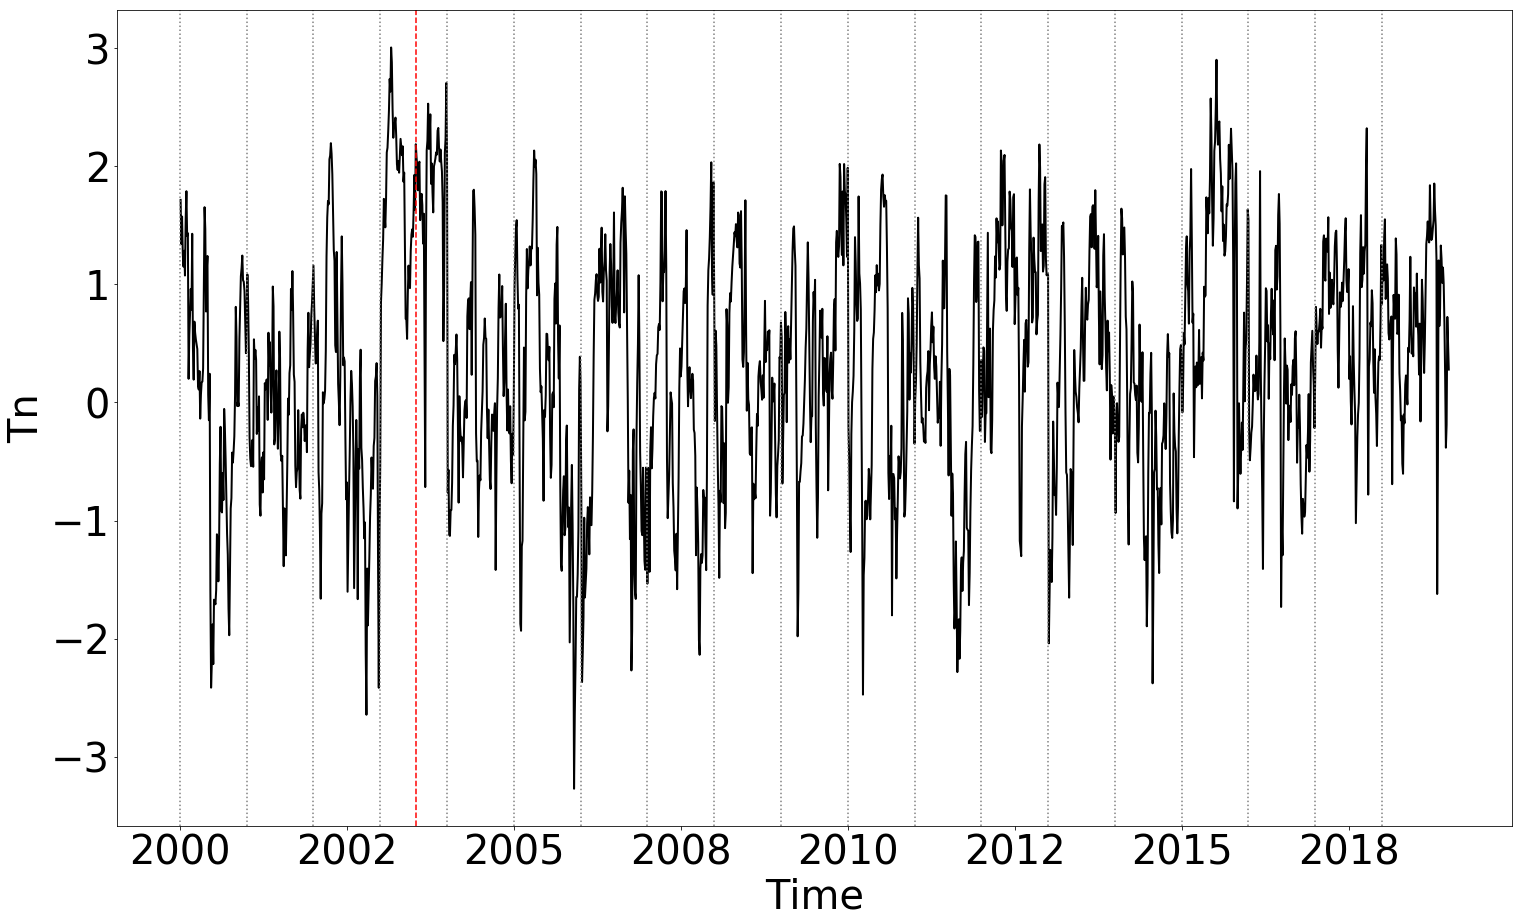

In [153]:
ts=data[:,latind,lonind]
abruptness_max=abruptness[latind,lonind]
fig = plt.figure()

fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

ax.plot(days, ts, 'k', linewidth='2')

## determine year of abrupt shift
index=np.where(abruptness3d[:,latind,lonind]==abruptness_max)

ax.axvline(x=days[index], ymin=0, ymax=1, color='r', linestyle="--")

plt.ylabel('Tn', fontsize=fntsiz)
plt.xlabel('Time', fontsize=fntsiz)
matplotlib.rc('xtick', labelsize=fntsiz) 
matplotlib.rc('ytick', labelsize=fntsiz) 
ax.tick_params(axis='both', which='major', labelsize=fntsiz)
for year in years:
    ax.axvline(x=year, ymin=0, ymax=1, color='gray', linestyle=":")

ymin=min(ts)
ymax=max(ts)
xmin=min(days)
xmax=max(days)
xrange=xmax-xmin
yrange=ymax-ymin
frac=0.025
ypos=ymax-0.025*yrange
xpos=xmin+0.01*xrange


<Figure size 1800x1080 with 0 Axes>

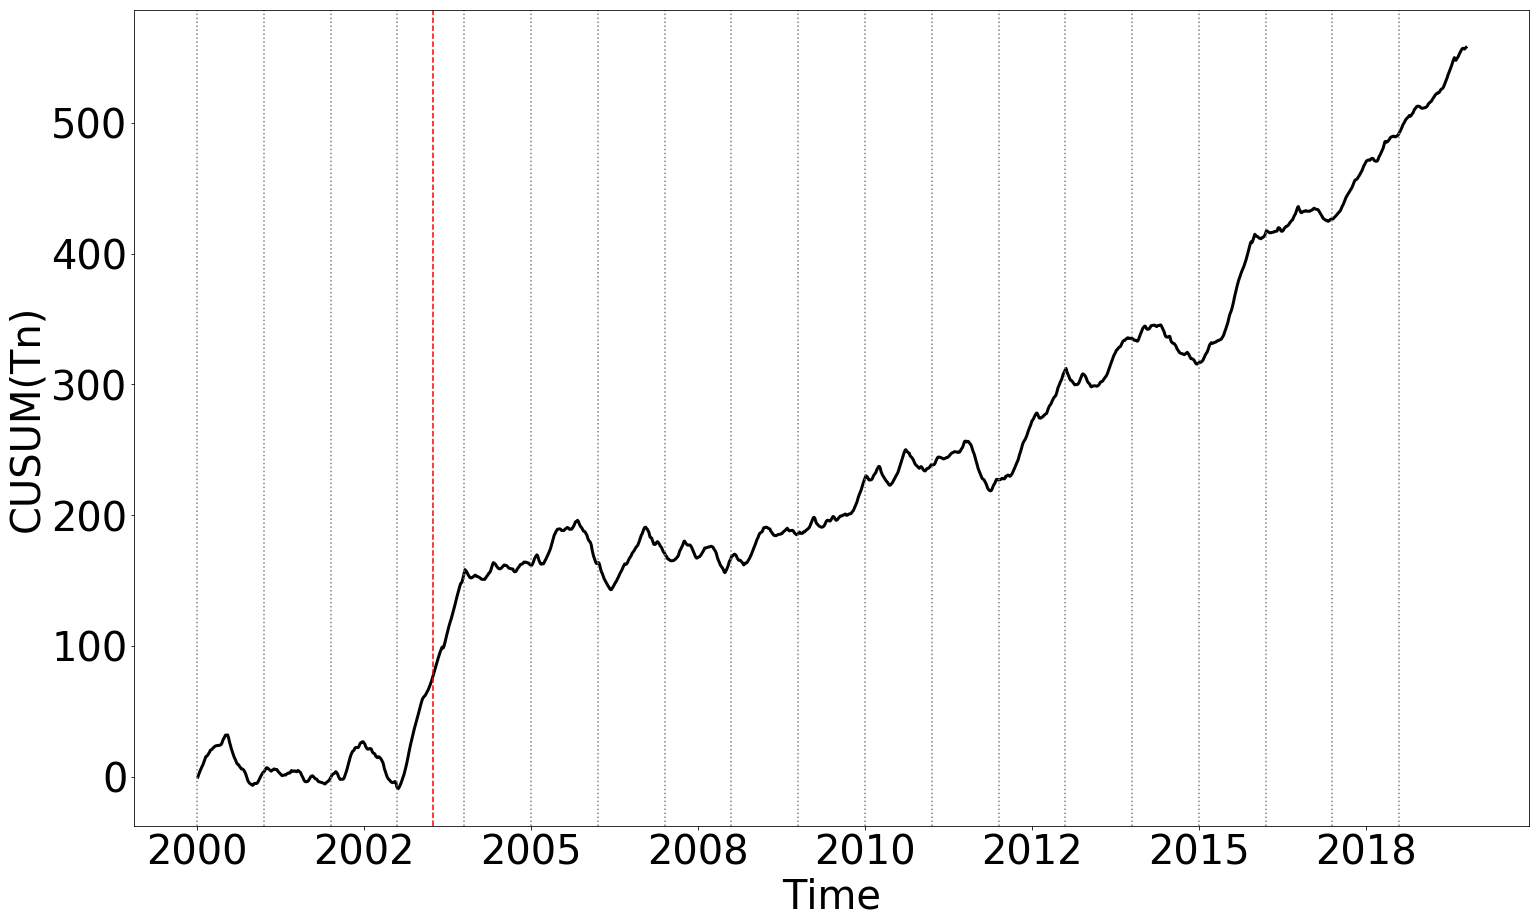

In [154]:
ts=data_int[:,latind,lonind]
fig = plt.figure()
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.plot(days, ts, 'k', linewidth='3')

ax.axvline(x=days[index], ymin=0, ymax=1, color='r', linestyle="--")

plt.ylabel('CUSUM(Tn)', fontsize=fntsiz)
plt.xlabel('Time', fontsize=fntsiz)
matplotlib.rc('xtick', labelsize=fntsiz) 
matplotlib.rc('ytick', labelsize=fntsiz) 
ax.tick_params(axis='both', which='major', labelsize=fntsiz)
for year in years:
    ax.axvline(x=year, ymin=0, ymax=1, color='gray', linestyle=":")

ymin=min(ts)
ymax=max(ts)
yrange=ymax-ymin
frac=0.025
ypos=ymax-0.025*yrange
xpos=xmin+0.01*xrange
#ax.text(xpos,ypos,'abruptness: '+ '{:f}'.format(abruptness_max),color='r', size=fntsiz)